<a href="https://colab.research.google.com/github/yuvalofek/MultiprocessingMatMul/blob/main/Multiprocessing_Matrix_Multiplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiprocessing for Matrix Multiplication

An investigation of multi and single core multiprocessing using concurrent futures ThreadPoolExecuter, ProcessPoolExecutor, as well as the threading  and multiprocessing libraries. 


The plan is to create functions using each one of the above tools, potentially using the same tool multiple times in different ways, and testing to see which ends up being faster. 


In [118]:
import concurrent.futures as cp
import threading
import multiprocessing

import random
import numpy as np
import time

from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Dot Product:
The first idea I had was to try to first do dot products, and then build them up into matrix multiplication. 

A traditional dot product is:
\begin{equation}
  \text{dot}(x,y) = y^Tx
\end{equation}

Or:

\begin{equation}
  \text{dot}(x,y) = \sum _{i=0}^N{x_iy_i^T}
\end{equation}

I create a function:
\begin{equation}
  \mathsf{F}(x, y^T) \rightarrow dot(x,y)
\end{equation}


### Functions created
I ended up creating a number of versions of the dot product function, mainly under these following umbrellas:
* Using only standard python, to use as a baseline
* Using concurrent.futures ThreadPoolExecuter
* Using concurrent.futures ProcessPoolExecuter
* Using Threading Thread
* Using Multiprocessing Pool

In [119]:
dot_product_functions = {}

#### Pure Python

In [120]:
def dot_prod_nothing(x,y, nothing=None):
  """
  Dot product of two vectors (without transpose) using Python
  params:
  x, y - vectors of same length
  nothing - (unused)
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  # thread the multiplications and add sequentially
  ip = 0
  for i in range(len(x)):
    ip += x[i]*y[i]
  return ip

dot_product_functions['Python'] = dot_prod_nothing

In [121]:
def mult(x,y):
  return x*y

#### Concurrent.futures

In [122]:
def dot_prod_map_th(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using ThreadPoolExecutor and map
  params:
  x, y - vectors of same length
  max_workers - maximum workers
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  ip = 0
  with cp.ThreadPoolExecutor(max_workers=max_workers) as ex:
    r = ex.map(mult, x, y)
    for l in r:
      ip+=l
  return ip

dot_product_functions['ThreadPool_map'] = dot_prod_map_th

In [123]:
def dot_prod_map_mult(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using ProcessPoolExecutor and map
  params:
  x, y - vectors of same length
  max_workers - maximum workers
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  ip = 0
  with cp.ProcessPoolExecutor(max_workers=max_workers) as ex:
    r = ex.map(mult, x, y)
    for l in r:
      ip+=l
  return ip

dot_product_functions['ProcessPool_map'] = dot_prod_map_mult

In [124]:
def dot_prod_sub_th(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using ThreadPoolExecutor and submit
  params:
  x, y - vectors of same length
  max_workers - maximum workers
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  # thread the multiplications and add sequentially
  ip = 0
  with cp.ThreadPoolExecutor(max_workers=max_workers) as ex:
    for i in range(len(x)):      
      ip+= ex.submit(mult, x[i], y[i]).result()
  return ip

dot_product_functions['ThreadPool_submit'] = dot_prod_sub_th

In [125]:
def dot_prod_sub_mult(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using ProcessPoolExecutor and submit
  params:
  x, y - vectors of same length
  max_workers - maximum workers
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  ip = 0
  with cp.ProcessPoolExecutor(max_workers=max_workers) as ex:
    for i in range(len(x)):      
      ip+= ex.submit(mult, x[i], y[i]).result()
  return ip

dot_product_functions['ProcessPool_submit'] = dot_prod_sub_mult

In [126]:
# dot product with execute instead
def dot_prod_ac(x,y, max_workers=None):

  """
  Dot product of two vectors (without transpose) using ThreadPoolExecutor, submit, and as_completed
  params:
  x, y - vectors of same length
  max_workers - maximum workers
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  # thread the multiplications and add sequentially
  ip = 0
  with cp.ThreadPoolExecutor(max_workers=max_workers) as ex:
      mults = [ex.submit(mult, x[i], y[i]) for i in range(len(x))]
  for multiples in cp.as_completed(mults):
    ip+=multiples.result()
  return ip

dot_product_functions['ThreadPool_submit_ac'] = dot_prod_ac

In [127]:
# dot product with execute instead
def dot_prod_ac_mult(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose)using ProcessdPoolExecutor, submit, and as_completed
  params:
  x, y - vectors of same length
  max_workers - maximum workers
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  ip = 0
  with cp.ProcessPoolExecutor(max_workers=max_workers) as ex:
      mults = [ex.submit(mult, x[i], y[i]) for i in range(len(x))]
  for multiples in cp.as_completed(mults):
    ip+=multiples.result()
  return ip

dot_product_functions['ProcessPool_submit_ac'] = dot_prod_ac_mult

#### Threading Library

In [128]:
# threading only
def dot_prod_thread(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using the threading Thread
  params:
  x, y - vectors of same length
  max_workers - maximum workers for threading (unused)
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  # thread the multiplications and add sequentially
  ip = 0
  threads = []
  results = []
  for i in range(len(x)):
    t = threading.Thread(target=mult_r, args = (x[i],y[i], results))
    t.start()
    threads.append(t)
  
  for t in threads:
    t.join()
  for r in results:
    ip+= r
  return ip

def mult_r(x,y, results):
  results.append(x*y)


dot_product_functions['Threading_threads'] = dot_prod_thread

#### Multiprocessing Library

In [129]:
def dot_prod_multiprocess_apply(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using the Pool apply
  params:
  x, y - vectors of same length
  max_workers - maximum workers for threading (unused)
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  # thread the multiplications and add sequentially
  ip = 0
  r = []
  with multiprocessing.Pool() as p:
    for i in range(len(x)):
      r.append(p.apply(mult, (x[i], y[i])))
    for l in r:
      ip+=l

  return ip

dot_product_functions['Multiprocessing_lib_apply'] = dot_prod_multiprocess_apply

In [130]:
def dot_prod_multiprocess_apply_async(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using the Pool apply_async
  params:
  x, y - vectors of same length
  max_workers - maximum workers for threading (unused)
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  # thread the multiplications and add sequentially
  ip = 0
  r = []
  with multiprocessing.Pool() as p:
    for i in range(len(x)):
      r.append(p.apply_async(mult, (x[i], y[i])).get())
    for l in r:
      ip+=l

  return ip

dot_product_functions['Multiprocessing_lib_apply_async'] = dot_prod_multiprocess_apply_async

In [131]:
def dot_prod_multiprocess_starmap(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using the Pool starmap
  params:
  x, y - vectors of same length
  max_workers - maximum workers for threading (unused)
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  # thread the multiplications and add sequentially
  ip = 0
  with multiprocessing.Pool() as p:
    r = p.starmap(mult, zip(x, y))
    for l in r:
      ip+=l
  return ip


dot_product_functions['Multiprocessing_lib_starmap'] = dot_prod_multiprocess_starmap

In [132]:
def dot_prod_multiprocess_starmap_async(x,y, max_workers=None):
  """
  Dot product of two vectors (without transpose) using the Pool starmap_async
  params:
  x, y - vectors of same length
  max_workers - maximum workers for threading (unused)
  """
  # check that the vector sizes are the same
  if len(x) != len(y):
    raise ValueError(f'Length of vectors {x} & {y} is not equal')
  
  # thread the multiplications and add sequentially
  ip = 0
  with multiprocessing.Pool() as p:
    r = p.starmap_async(mult, zip(x, y))
    for l in r:
      ip+=l
  return ip


dot_product_functions['Multiprocessing_lib_starmap_async'] = dot_prod_multiprocess_starmap

In [133]:
# Numpy
dot_product_functions['numpy'] = lambda x, y, mx_workers: np.dot(x,y)

### Testing
First we do a small test to see that everything is going well, then we do a stress test with a large input value

In [134]:
# Contrived test case:
x = [1,2,3, 4]
y = x[::-1]
results = {name:dot_product(x,y, 1) for name, dot_product in dot_product_functions.items()}

for name, result in results.items():
  print(name, ': ', result)

# 1*4 + 2*3 + 3*2 +4*1 = 4 + 6 + 6 + 4 = 20

Python :  20
ThreadPool_map :  20
ProcessPool_map :  20
ThreadPool_submit :  20
ProcessPool_submit :  20
ThreadPool_submit_ac :  20
ProcessPool_submit_ac :  20
Threading_threads :  20
Multiprocessing_lib_apply :  20
Multiprocessing_lib_apply_async :  20
Multiprocessing_lib_starmap :  20
Multiprocessing_lib_starmap_async :  20
numpy :  20


In [135]:
# Random test case:
MAX_SIZE = 100
MAX_STDV = 10
n = 5000
x_stdv, y_stdv = random.randint(1,MAX_STDV), random.randint(1,MAX_STDV)
x = (x_stdv*np.random.randn(n))
y = (y_stdv*np.random.randn(n))
print(f'Vector size: {n}')

results = defaultdict(list)
durations = defaultdict(list)
mx_workers = [None]
mx_workers.extend(range(1, 10))
for i in tqdm(mx_workers):  
  for name, dot_prod in dot_product_functions.items():
    start_time = time.time()
    if name== 'numpy':
      results[name].append(dot_prod(x,y, i).tolist())
    else:
      results[name].append(dot_prod(x,y, i))
    durations[name].append(time.time() - start_time)




print('')
print('Average Results')
for name, result in results.items():
  print(name, ': ', sum(result)/len(result))

print('')
print('Average Duration')
for name, duration in durations.items():
  print(name, ': ', sum(duration)/len(duration))


Vector size: 5000


100%|██████████| 10/10 [02:08<00:00, 12.89s/it]


Average Results
Python :  -846.7856335255326
ThreadPool_map :  -846.7856335255326
ProcessPool_map :  -846.7856335255326
ThreadPool_submit :  -846.7856335255326
ProcessPool_submit :  -846.7856335255326
ThreadPool_submit_ac :  -846.785633525529
ProcessPool_submit_ac :  -846.7856335255283
Threading_threads :  -846.7856335255326
Multiprocessing_lib_apply :  -846.7856335255326
Multiprocessing_lib_apply_async :  -846.7856335255326
Multiprocessing_lib_starmap :  -846.7856335255326
Multiprocessing_lib_starmap_async :  -846.7856335255326
numpy :  -846.7856335255265

Average Duration
Python :  0.004131388664245605
ThreadPool_map :  0.19158742427825928
ProcessPool_map :  2.3921554327011108
ThreadPool_submit :  0.36130361557006835
ProcessPool_submit :  3.196423578262329
ThreadPool_submit_ac :  0.20751581192016602
ProcessPool_submit_ac :  2.215308928489685
Threading_threads :  0.6531060218811036
Multiprocessing_lib_apply :  1.657722043991089
Multiprocessing_lib_apply_async :  1.6613504409790039
Mu

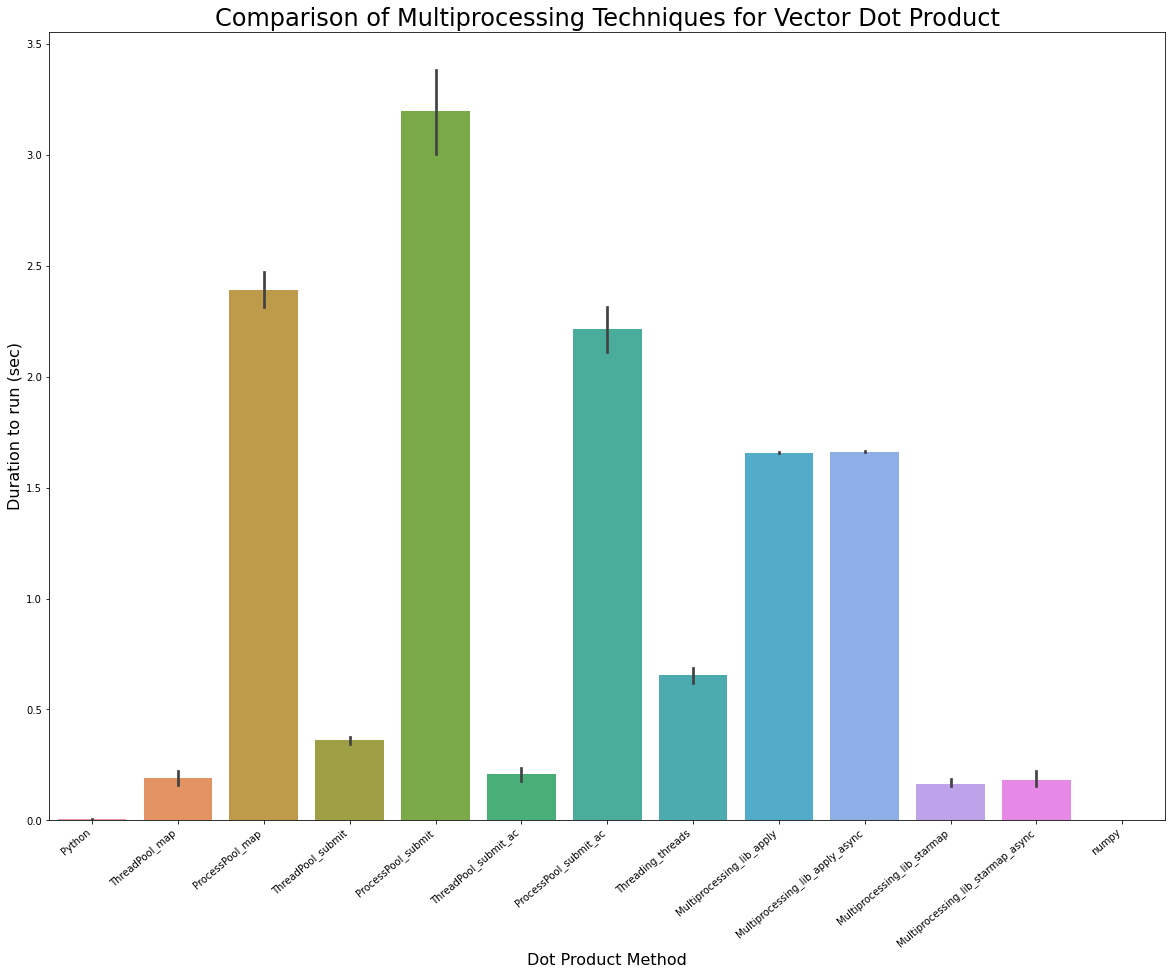

In [136]:
plt.figure(figsize=(20, 15))
ax = sns.barplot(data=pd.DataFrame(durations), orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Dot Product Method', fontsize=16)
plt.ylabel('Duration to run (sec)', fontsize=16)
plt.title('Comparison of Multiprocessing Techniques for Vector Dot Product', fontsize=24)
plt.subplots_adjust(bottom=0.15)
plt.savefig('dt_prod_comp.png')
plt.show()

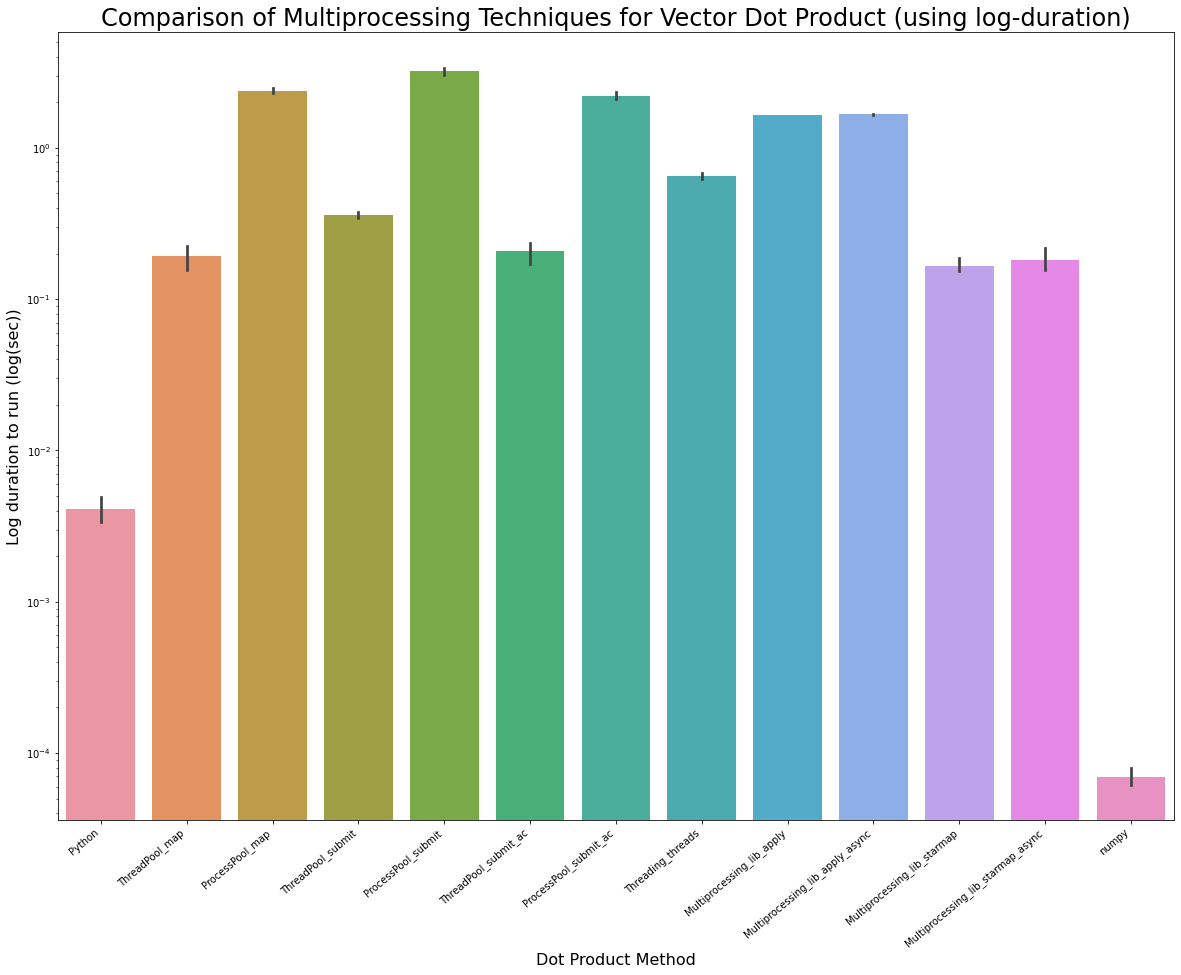

In [138]:
plt.figure(figsize=(20, 15))
ax = sns.barplot(data=pd.DataFrame(durations), orient='v')
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Dot Product Method', fontsize=16)
plt.ylabel('Log duration to run (log(sec))', fontsize=16)
plt.title('Comparison of Multiprocessing Techniques for Vector Dot Product (using log-duration)', fontsize=24)
plt.subplots_adjust(bottom=0.15)
plt.savefig('log_dt_prod_comp.png')
plt.show()

### Conclusions:
Given the strain test test, we see that using Multiprocessing starmap was the fastest out of the multiprocessing options, but that using nothing at all was (significantly) faster (and numpy is of course even faster than that)! We opt to use the python version because of this for the matrix multiplication.

This is likely telling us that multiprocessing multiplication like this is not benefitial, maybe because of the additional calls and overhead costs.

Another interesting thing we see is that the as_completed inner product doesn't match the other inner_products exactly.  

## Matrix multiplication

Matrix multiplication is of the form:
\begin{equation}
  \mathsf{M}_{n \text{x} m}(\mathbb{R}) * \mathsf{M}_{m \text{x} l}(\mathbb{R}) \rightarrow \mathsf{M}_{n \text{x} l}(\mathbb{R})
\end{equation}

Therefore we do:
1. Check that the inputs are matrices
2. Check that the inner matrix dimenstions $m$ match for the two matrices
3. Preform matrix multiplication

We use the 'normal' python version as our 'inner product component' in the following functions and only consider creating functions for the top 5 performing methods from the inner product functions:
1. ThreadPool Map
2. ThreadPool Submit
3. ThreadPool Submit as_completed
4. Multiprocessing Starmap
5. Multiprocessing Starmap_async

We don't create the submit as_completed function. This is due to the need to know which inner product belongs where, which isn't suitable for the as_completed method

In [83]:
def is_matrix(X):
  ## Check if the input is a matrix
  lengths = map(len, X)
  try:
    # first length
    first = next(lengths)
  except StopIteration:
    return True
  return all(first == x for x in lengths)

In [84]:
# Testing the is_matrix funciton:
is_matrix([[1, 2], [3], [1,3]]) # False

False

In [85]:
mat_mul_functions = {}

In [99]:
def mat_mul_nothing(X, Y, i):
  # check that the inputs are valid matrices
  if not is_matrix(X):
    raise ValueError(f'Input {X} is not a matrix')
  if not is_matrix(Y):
    raise ValueError(f'Input {Y} is not a matrix')
  
  # check that the dimensions of the matrices are valid for multiplication
  # and save lengths
  n, m, l = len(X), len(X[0]), len(Y[0])
  if m != len(Y):
    raise ValueError('Dimensions of X and Y do not match')

  # thread each of the inner products
  output = [[0 for j in range(l)] for i in range(n) ]
  for i in range(n):
    for j in range(l):
      x =  X[i]
      y = [row[j] for row in Y]    
      output[i][j] = dot_prod_nothing(x, y)
        
  return output

mat_mul_functions['Python'] = mat_mul_nothing

In [100]:
# Checking the list transpose we found here: https://stackoverflow.com/questions/6473679/transpose-list-of-lists
#np.array(list(map(list, zip(*Y)))) == np.array(Y).T

In [101]:
def mat_mul_submit(X, Y, max_workers=None):
  # check that the inputs are valid matrices
  if not is_matrix(X):
    raise ValueError(f'Input X is not a matrix')
  if not is_matrix(Y):
    raise ValueError(f'Input Y is not a matrix')
  
  # check that the dimensions of the matrices are valid for multiplication
  n, m, l = len(X), len(X[0]), len(Y[0])
  if m != len(Y):
    raise ValueError('Dimensions of X and Y do not match')

  # thread each of the inner products
  output = [[0 for j in range(l)] for i in range(n) ]
  with cp.ThreadPoolExecutor(max_workers=max_workers) as ex:
    for i in range(n):
      for j in range(l):
        x =  X[i]
        y = [row[j] for row in Y]    
        output[i][j] = ex.submit(dot_prod_nothing, x, y).result()
  return output

mat_mul_functions['ThreadPool_submit'] = mat_mul_submit

In [102]:
def mat_mul_map(X, Y, max_workers=None):
  # check that the inputs are valid matrices
  if not is_matrix(X):
    raise ValueError(f'Input X is not a matrix')
  if not is_matrix(Y):
    raise ValueError(f'Input Y is not a matrix')
  
  # check that the dimensions of the matrices are valid for multiplication
  n, m, l = len(X), len(X[0]), len(Y[0])
  if m != len(Y):
    raise ValueError('Dimensions of X and Y do not match')

  output = [[] for i in range(n) ]
  # thread each of the inner products
  Y = list(map(list, zip(*Y)))
  with cp.ThreadPoolExecutor(max_workers=max_workers) as ex:
    for i in range(n):
      output[i] = list(ex.map(dot_prod_nothing, [X[i]]*n, Y))
  return output

mat_mul_functions['ThreadPool_map'] = mat_mul_map

In [103]:
def mat_mul_multi_starmap(X, Y, max_workers=None):
  # check that the inputs are valid matrices
  if not is_matrix(X):
    raise ValueError(f'Input X is not a matrix')
  if not is_matrix(Y):
    raise ValueError(f'Input Y is not a matrix')
  
  # check that the dimensions of the matrices are valid for multiplication
  n, m, l = len(X), len(X[0]), len(Y[0])
  if m != len(Y):
    raise ValueError('Dimensions of X and Y do not match')

  output = [[] for i in range(n) ]
  # thread each of the inner products
  Y = list(map(list, zip(*Y)))
  with multiprocessing.Pool() as p:
    for i in range(n):
      output[i] = list(p.starmap(dot_prod_nothing, zip([X[i]]*n, Y)))
  return output

mat_mul_functions['Multiprocessing_starmap'] = mat_mul_multi_starmap

In [104]:
def mat_mul_multi_starmap_async(X, Y, max_workers=None):
  # check that the inputs are valid matrices
  if not is_matrix(X):
    raise ValueError(f'Input X is not a matrix')
  if not is_matrix(Y):
    raise ValueError(f'Input Y is not a matrix')
  
  # check that the dimensions of the matrices are valid for multiplication
  n, m, l = len(X), len(X[0]), len(Y[0])
  if m != len(Y):
    raise ValueError('Dimensions of X and Y do not match')

  output = [[] for i in range(n) ]
  # thread each of the inner products
  Y = list(map(list, zip(*Y)))
  with multiprocessing.Pool() as p:
    for i in range(n):
      output[i] = p.starmap_async(dot_prod_nothing, zip([X[i]]*n, Y)).get()
  return output

mat_mul_functions['Multiprocessing_starmap_async'] = mat_mul_multi_starmap_async

In [105]:
# add numpy
mat_mul_functions['numpy'] = lambda x, y, mx: np.matmul(x,y)

In [106]:
# Random test case
MAX_SIZE = 10
MAX_STDV = 10
N = 300
n, m, l = N, N, N 
x_stdv, y_stdv = random.randint(1,MAX_STDV), random.randint(1,MAX_STDV)
X = (x_stdv*np.random.randn(n, m))
Y = (y_stdv*np.random.randn(m, l))

X = X.tolist()
Y = Y.tolist()



results = defaultdict(list)
durations = defaultdict(list)
mx_workers = [None]
mx_workers.extend(range(1, 10))

for i in tqdm(mx_workers):
  for name, mat_mul in mat_mul_functions.items():
    start_time = time.time()
    results[name].append(mat_mul(X, Y, i))
    durations[name].append(time.time() - start_time)

avg = []
print('')
check = True
old_val = None
for name, result in results.items():
  mean_result = np.mean(np.stack([np.array(r) for r in result]), axis=0)
  try:
    old_val == None
    old_val =mean_result
  except:
    check = check & (mean_result == old_val).all()

  print(name, mean_result.shape)
  print('Result matches previous: ', check)

print('')
print('Average Duration')
for name, duration in durations.items():
  print(name, ': ', sum(duration)/len(duration))

100%|██████████| 10/10 [07:05<00:00, 42.51s/it]



Python (300, 300)
Result matches previous:  True
ThreadPool_submit (300, 300)
Result matches previous:  True
ThreadPool_map (300, 300)
Result matches previous:  True
Multiprocessing_starmap (300, 300)
Result matches previous:  True
Multiprocessing_starmap_async (300, 300)
Result matches previous:  True
numpy (300, 300)
Result matches previous:  True

Average Duration
Python :  5.412179064750672
ThreadPool_submit :  18.87031545639038
ThreadPool_map :  6.16217041015625
Multiprocessing_starmap :  6.020190358161926
Multiprocessing_starmap_async :  6.027068710327148
numpy :  0.012439990043640136


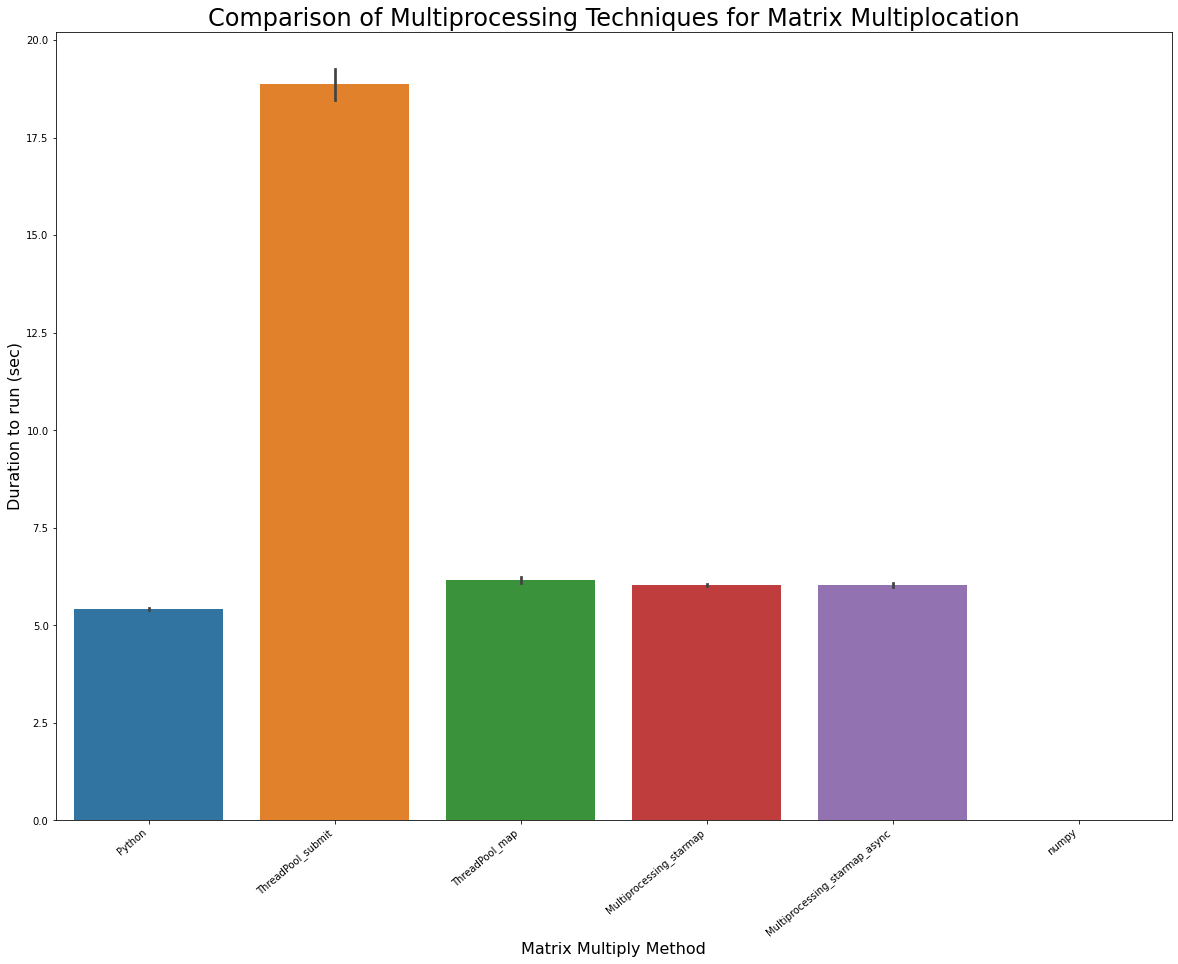

In [116]:
plt.figure(figsize=(20, 15))
ax = sns.barplot(data=pd.DataFrame(durations), orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Matrix Multiply Method', fontsize=16)
plt.ylabel('Duration to run (sec)', fontsize=16)
plt.title('Comparison of Multiprocessing Techniques for Matrix Multiplocation', fontsize=24)
plt.subplots_adjust(bottom=0.15)
plt.savefig('matmul_comp.png')
plt.show()

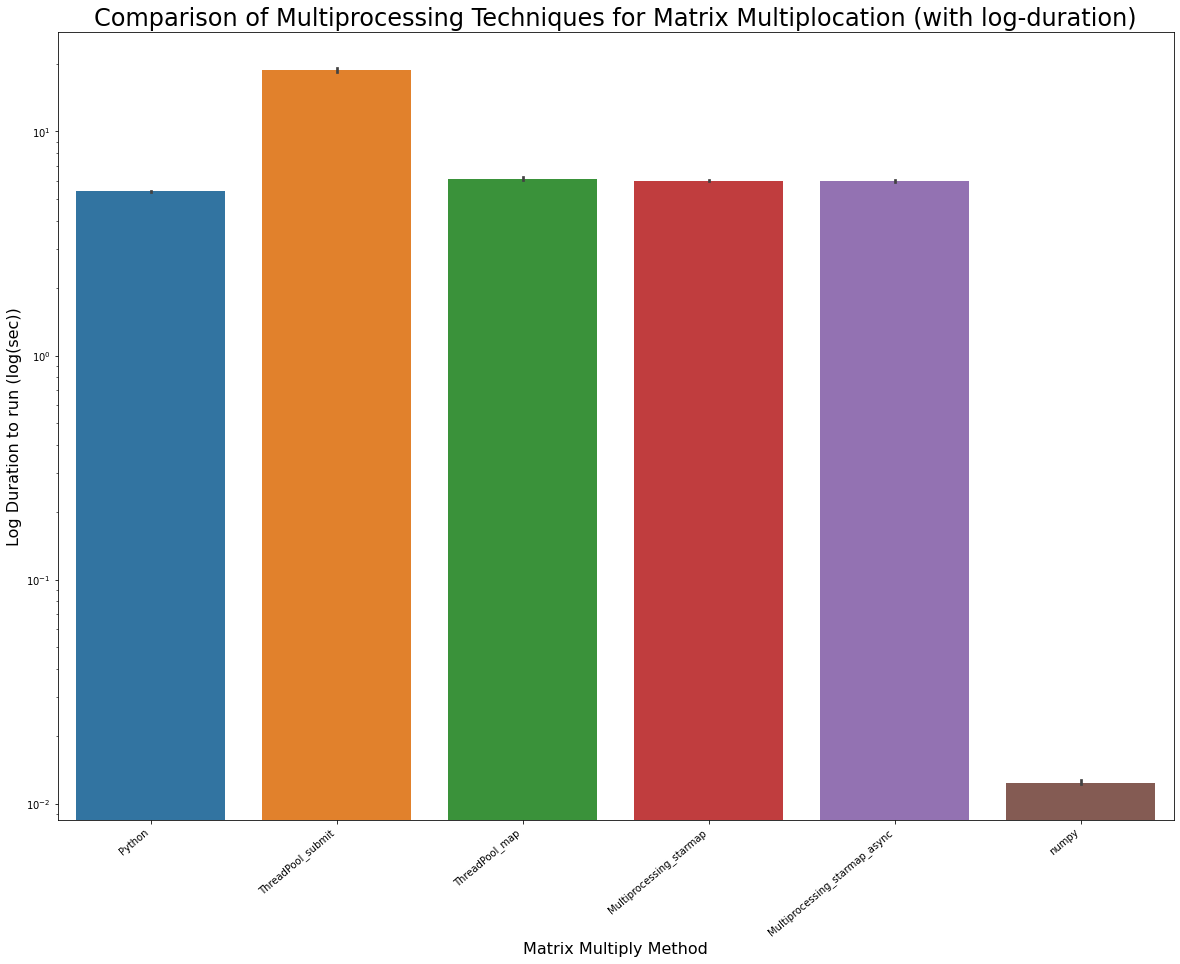

In [117]:
plt.figure(figsize=(20, 15))
ax = sns.barplot(data=pd.DataFrame(durations), orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Matrix Multiply Method', fontsize=16)
plt.ylabel('Log Duration to run (log(sec))', fontsize=16)
plt.title('Comparison of Multiprocessing Techniques for Matrix Multiplocation (with log-duration)', fontsize=24)
plt.subplots_adjust(bottom=0.15)
plt.yscale('log')
plt.savefig('log_matmul_comp.png')
plt.show()

### Conclusions:

Once again we see that threading didn't help at all and that numpy is the way to go for any matrix multiplication operation. We see how significant the speed-up numpy gives us and how much time we would be waisting if we didn't use it. 

It makes sense that the python only version was faster than threading looking back, because matrix multiplication involves a bunch of very simple operations and maybe the overhead was too much. 